In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import time
from collections import Counter
import os
import tensorflow as tf

In [2]:
# Paths to your data directories
train_data_dir = '/kaggle/input/emotion/FER24_CK+_6000+_600_600_NoEnhance_7Emo/train'
validation_data_dir = '/kaggle/input/emotion/FER24_CK+_6000+_600_600_NoEnhance_7Emo/valid'
test_data_dir = '/kaggle/input/emotion/FER24_CK+_6000+_600_600_NoEnhance_7Emo/test'
image_size = (224, 224)
batch_size = 32
num_classes = 7

In [3]:
# ImageDataGenerator for training, validation, and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Define a function to get images and labels
def get_data_generator(directory, datagen, batch_size, image_size, color_mode, shuffle=True):
    return datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode='categorical',
        shuffle=shuffle
    )

train_generator = get_data_generator(train_data_dir, train_datagen, batch_size, image_size, 'grayscale')
validation_generator = get_data_generator(validation_data_dir, valid_test_datagen, batch_size, image_size, 'grayscale')
test_generator = get_data_generator(test_data_dir, valid_test_datagen, batch_size, image_size, 'grayscale', shuffle=False)

Found 48618 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.regularizers import l2

def f1_score(y_true, y_pred):
    precision = Precision()
    recall = Recall()
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return 2 * ((precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon()))  

# Fonction pour créer le modèle EfficientNetB3
def create_efficientnetb3(input_shape=(224, 224, 3)):
    # Conversion de l'image grayscale en 3 canaux
    input_layer = Input(shape=(224, 224, 1))  # Image en grayscale
    x = Conv2D(3, (1, 1), padding='same')(input_layer)  # Convertir en 3 canaux
    
    # Charger le modèle pré-entraîné EfficientNetB3
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))(x)
    
    # Appliquer un pooling global et une couche dense
    x = GlobalAveragePooling2D()(base_model)
# Ajouter une couche dense avec régularisation L2 et Dropout
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Ajouter un Dropout pour éviter l'overfitting
    output = Dense(num_classes, activation='softmax')(x)
    
    # Créer le modèle final
    model = Model(inputs=input_layer, outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["acc", Precision(), Recall()])
    return model

# Créer et afficher le résumé du modèle
model_efficientnetb3 = create_efficientnetb3()
model_efficientnetb3.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,574,076 (44.15 MB)

 Trainable params: 11,486,773 (43.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return 2 * ((precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon()))

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7, verbose=1)



In [8]:
import os
import time
from tensorflow.keras.callbacks import ModelCheckpoint

# Créer le répertoire de sauvegarde si nécessaire
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

# Définir le callback de sauvegarde du modèle
checkpoint_callback = ModelCheckpoint(
    'checkpoints/model_checkpoints_epoch_{epoch:02d}.keras',  # Sauvegarde dans 'checkpoints'
    save_weights_only=False,  # Sauvegarder le modèle complet, pas seulement les poids
    save_best_only=False,  # Sauvegarder à chaque époque
    save_freq='epoch',  # Sauvegarder à chaque époque
    verbose=1
)
# Tracker le temps d'entraînement
start_time = time.time()

# Prediction model
history = model_efficientnetb3.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[checkpoint_callback,early_stop, reduce_lr]
    )

end_time = time.time()
training_time = end_time - start_time

# Afficher le temps d'entraînement total
print(f"Temps total d'entraînement : {training_time:.2f} secondes.")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - acc: 0.4289 - loss: 6.2709 - precision: 0.6754 - recall: 0.2158
Epoch 1: saving model to checkpoints/model_checkpoints_epoch_01.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 664s 361ms/step - acc: 0.4289 - loss: 6.2696 - precision: 0.6754 - recall: 0.2159 - val_acc: 0.7048 - val_loss: 1.5792 - val_precision: 0.7779 - val_recall: 0.6348 - learning_rate: 1.0000e-04
Epoch 2/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - acc: 0.7088 - loss: 1.3011 - precision: 0.7935 - recall: 0.6102
Epoch 2: saving model to checkpoints/model_checkpoints_epoch_02.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 475s 312ms/step - acc: 0.7089 - loss: 1.3010 - precision: 0.7935 - recall: 0.6102 - val_acc: 0.7462 - val_loss: 0.8324 - val_precision: 0.7947 - val_recall: 0.6967 - learning_rate: 1.0000e-04
Epoch 3/10
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - acc: 0.7779 - loss: 0.7154 - precision: 0.8357 - recall: 0.7177
Epoch 3: saving model to checkpoints/model_checkpoints_epoc

In [9]:
# Print maximum accuracy
max_acc = max(history.history['val_acc'])
print("\n\nMaximum Accuracy Reached Is:", max_acc)



Maximum Accuracy Reached Is: 0.8057143092155457


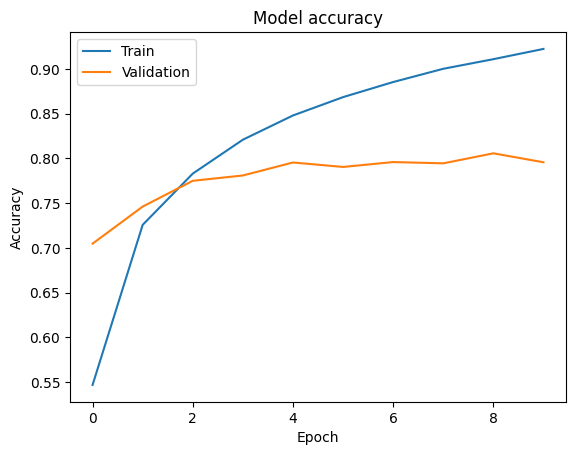

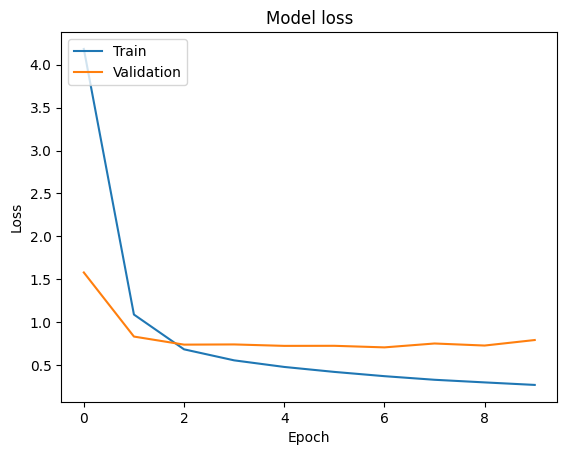

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
# Evaluate the model on the training data
results = model_efficientnetb3.evaluate(train_generator, steps=train_generator.samples // batch_size, verbose=2)
print('\nTraining results:', results)

# Unpack individual metrics
train_loss, train_acc, train_precision, train_recall = results
print('\nTraining accuracy:', train_acc)
print('\nTraining precision:', train_precision)
print('\nTraining recall:', train_recall)

# Evaluate the model on the test data
results = model_efficientnetb3.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=2)
print('\nTest results:', results)

# Unpack individual metrics
val_loss, val_acc, val_precision, val_recall = results
print('\nValidation accuracy:', val_acc)
print('\nValidation precision:', val_precision)
print('\nValidation recall:', val_recall)

1519/1519 - 247s - 163ms/step - acc: 0.9407 - loss: 0.2195 - precision: 0.9517 - recall: 0.9293

Training results: [0.21951310336589813, 0.9406682252883911, 0.9517318606376648, 0.9293326139450073]

Training accuracy: 0.9406682252883911

Training precision: 0.9517318606376648

Training recall: 0.9293326139450073
131/131 - 20s - 150ms/step - acc: 0.7839 - loss: 0.7699 - precision: 0.8013 - recall: 0.7660

Test results: [0.7699193358421326, 0.7838740348815918, 0.8013476133346558, 0.7659828066825867]

Validation accuracy: 0.7838740348815918

Validation precision: 0.8013476133346558

Validation recall: 0.7659828066825867


132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step


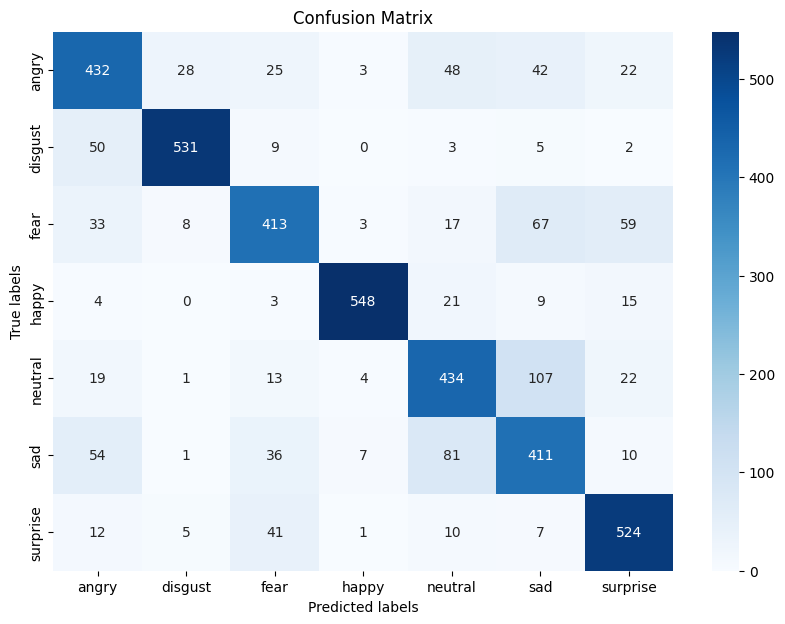

              precision    recall  f1-score   support

       angry       0.72      0.72      0.72       600
     disgust       0.93      0.89      0.90       600
        fear       0.76      0.69      0.72       600
       happy       0.97      0.91      0.94       600
     neutral       0.71      0.72      0.71       600
         sad       0.63      0.69      0.66       600
    surprise       0.80      0.87      0.84       600

    accuracy                           0.78      4200
   macro avg       0.79      0.78      0.79      4200
weighted avg       0.79      0.78      0.79      4200



In [12]:
# Predict classes for test set
test_generator.reset()  # Reset the generator to avoid any state issues
Y_pred = model_efficientnetb3.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Ensure the ground truth labels also cover all samples
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

In [13]:
import pandas as pd
# Classification Report
print(classification_report(test_generator.classes, y_pred, target_names=train_generator.class_indices.keys()))

# Tabulate cost efficiency information including accuracy and validation accuracy for each epoch
epochs = len(history.history['acc'])
cost_efficiency_data = {
    "Epoch": list(range(1, epochs + 1)),
    "Training Accuracy": history.history['acc'],
    "Validation Accuracy": history.history['val_acc']
}
cost_efficiency_df = pd.DataFrame(cost_efficiency_data)
print(cost_efficiency_df)
# Summary of overall cost efficiency
summary_data = {
    "Metric": ["Training Time (seconds)", "Final Validation Accuracy", "Final Training Accuracy", "Training Accuracy", "Test Accuracy"],
    "Value": [training_time, history.history['val_acc'][-1], history.history['acc'][-1], train_acc, val_acc]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

              precision    recall  f1-score   support

       angry       0.72      0.72      0.72       600
     disgust       0.93      0.89      0.90       600
        fear       0.76      0.69      0.72       600
       happy       0.97      0.91      0.94       600
     neutral       0.71      0.72      0.71       600
         sad       0.63      0.69      0.66       600
    surprise       0.80      0.87      0.84       600

    accuracy                           0.78      4200
   macro avg       0.79      0.78      0.79      4200
weighted avg       0.79      0.78      0.79      4200

   Epoch  Training Accuracy  Validation Accuracy
0      1           0.546876             0.704762
1      2           0.725760             0.746190
2      3           0.783043             0.775000
3      4           0.820931             0.780952
4      5           0.848019             0.795476
5      6           0.868526             0.790476
6      7           0.885392             0.795952
7      8   

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


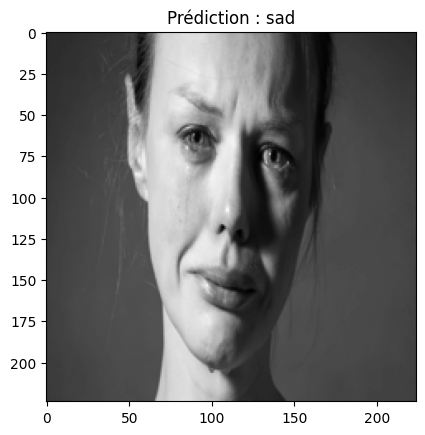

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


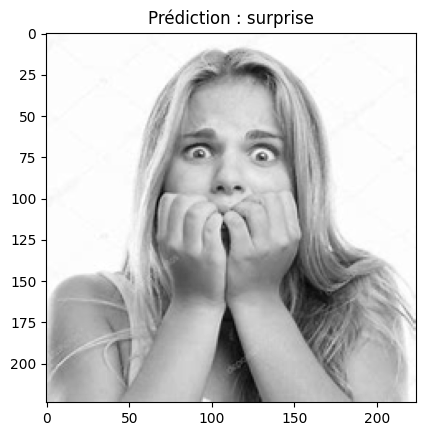

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


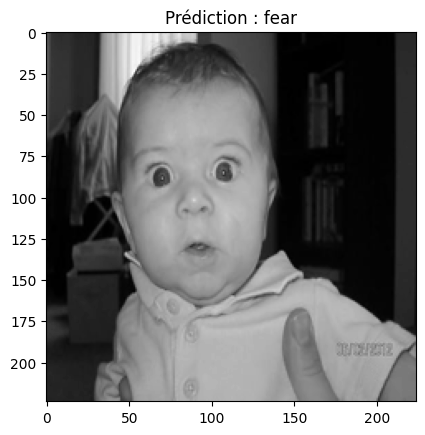

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


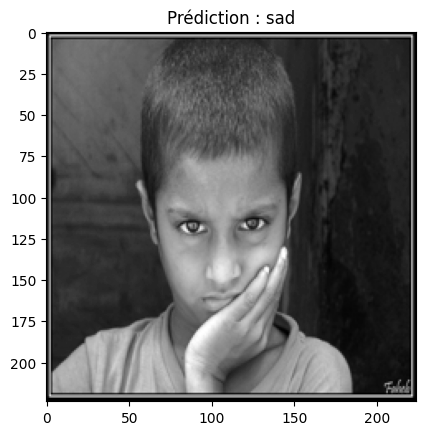

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


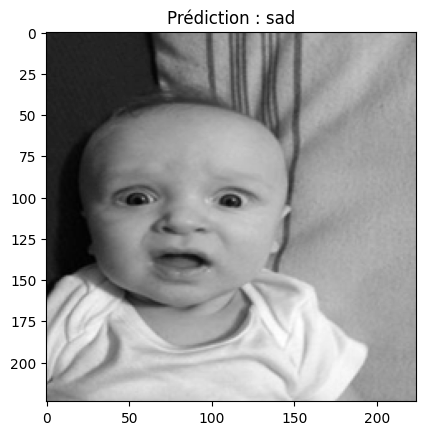

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


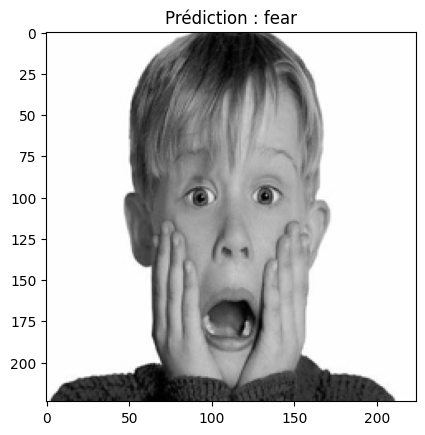

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


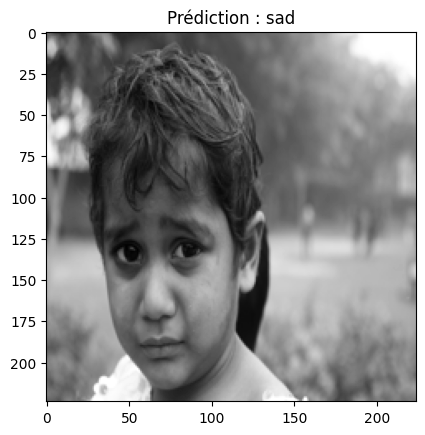

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


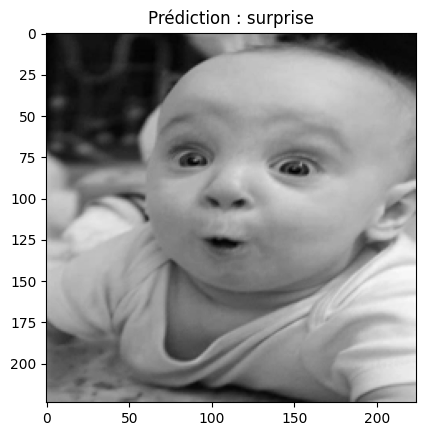

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


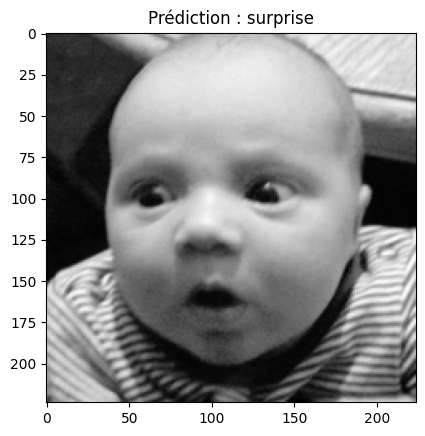

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


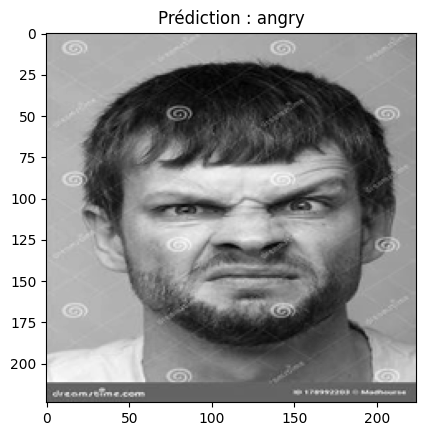

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


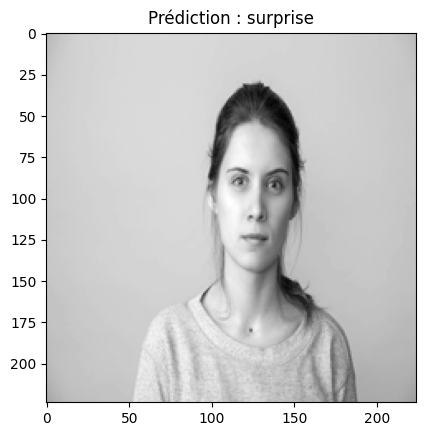

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


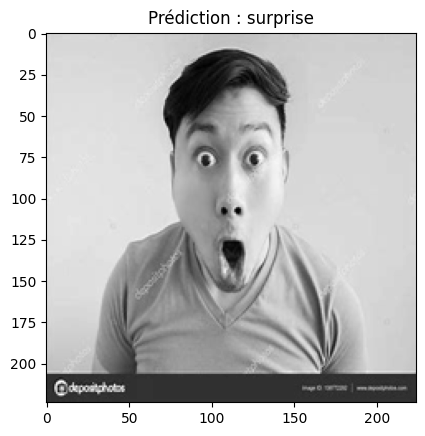

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


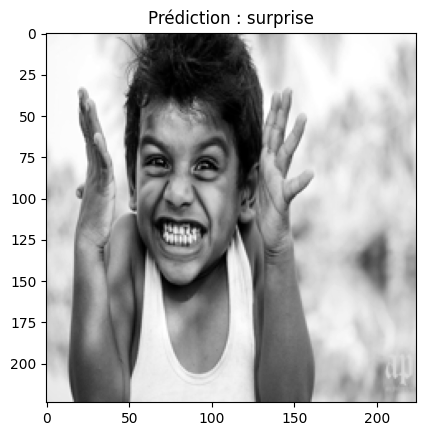

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


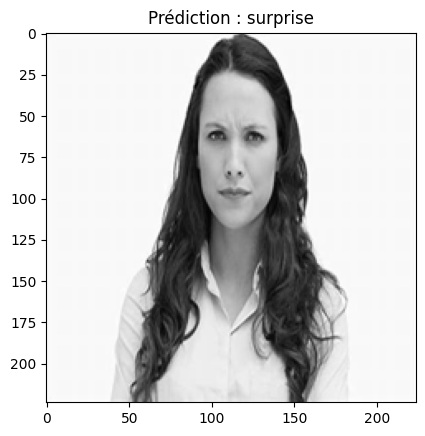

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


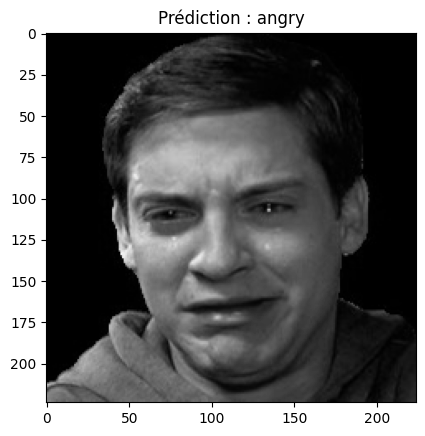

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


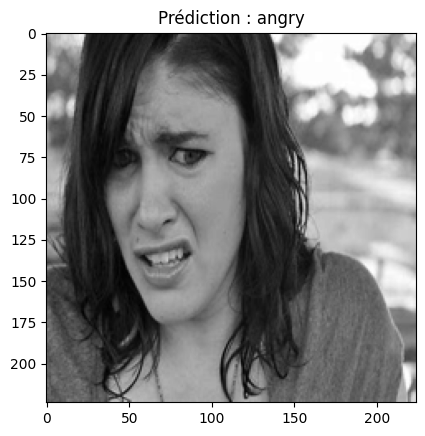

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


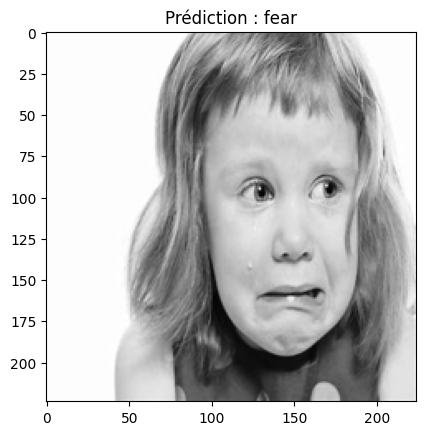

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


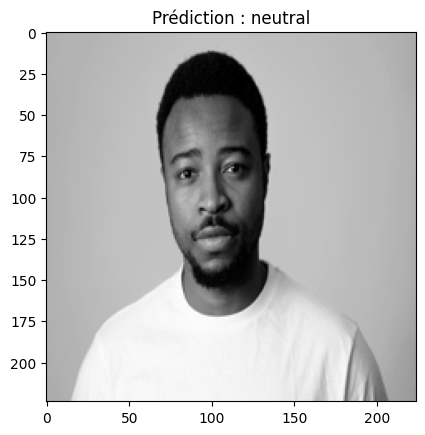

In [15]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Obtenir les classes du générateur
class_indices = train_generator.class_indices
label_map = {v: k for k, v in class_indices.items()}  # Mapping inverse

# Dossier contenant les images à tester
images_folder = '/kaggle/input/testemotion/'  

# Charger et traiter toutes les images du dossier
image_files = [f for f in os.listdir(images_folder) if f.endswith(('jpeg', 'png', 'jpg'))]  # Filtrer les fichiers d'image
# Parcourir chaque image
for img_file in image_files:
    img_path = os.path.join(images_folder, img_file)
    
    # Charger et prétraiter l'image
    img = Image.open(img_path).convert('L')  # Convertir en niveaux de gris
    img = img.resize((224, 224))  # Redimensionner
    img_array = np.array(img) / 255.0  # Normaliser les valeurs des pixels
    img_array = np.expand_dims(img_array, axis=-1)  # Ajouter la dimension de canal
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension de batch

    # Faire une prédiction
    predictions = model_efficientnetb3.predict(img_array)
    predicted_class = np.argmax(predictions)  # Obtenir l'indice de la probabilité maximale
    predicted_label = label_map[predicted_class]  # Mapper l'indice au nom de la classe

    # Afficher l'image et la prédiction
    plt.imshow(img, cmap='gray')
    plt.title(f"Prédiction : {predicted_label}")  # Afficher l'étiquette de la classe
    plt.show()